In [1]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_forecast_component
from prophet.serialize import model_to_json, model_from_json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import logging
import json
pd.set_option('display.max_columns', None)

In [2]:
IN_COLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

SAVE_FIGURES = True

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    CODE_PATH = '/content/drive/MyDrive/Trabajo profesional/Code/' # absolute path
else:
    CODE_PATH = '' # relative path

## Carga de datos

In [4]:
dataset_train = pd.read_csv(CODE_PATH + "data/prod_split_train_2024-05-28_15:05:17.csv", index_col=0, low_memory=False)
dataset_train["fecha"] = pd.to_datetime(dataset_train["fecha"])
# dataset_train.info()

In [5]:
dataset_test = pd.read_csv(CODE_PATH + "data/prod_split_test_2024-05-28_15:05:17.csv", index_col=0, low_memory=False)
dataset_test["fecha"] = pd.to_datetime(dataset_test["fecha"])
# dataset_test.info()

In [6]:
def load_algorithm_predictions(algo_name, file_name):
    dataset_algorithm = pd.read_csv(file_name, index_col=0, low_memory=False)
    dataset_algorithm["fecha"] = pd.to_datetime(dataset_algorithm["fecha"])
    dataset_algorithm.sort_values(by=['fecha', 'idpozo'], inplace=True)
    dataset_algorithm.reset_index(drop=True, inplace=True)
    return dataset_algorithm

### Carga de las predicciones de los distintos algoritmos

In [7]:
predictions_metadata = [
  ["GRU", "GRU", "gru_2024-06-16_22:34:41.csv"],
  ["GRU", "GRU filtro por área", "gru_agrupation_2024-06-16_22:43:56.csv"],
  ["Prophet", "Prophet", "prophet_single_2024-06-07_01:19:42.csv"],
  ["Prophet", "Prophet agregación total", "prophet_single_with_aggregate_2024-06-09_17:57:46.csv"],
  ["Prophet", "Prophet agregación por área", "prophet_single_with_area_aggregate_2024-06-11_03:49:54.csv"],
  ["ARIMA", "ARIMA", "arima_single.csv"],
  ["ARIMA", "ARIMA agregación total", "arima_total_mean.csv"],
  ["ARIMA", "ARIMA agregación por área", "arima_area_mean.csv"],
  ["LSTM", "LSTM - MSE 100 evals", "predictions_MSE_100_trials.csv"],
  ["LSTM", "LSTM agregación por área - MSE 100 evals", "LSTM_predictions_agregacion_MSE_100_trials.csv"],
  ["LSTM", "LSTM agregación total - MSE 50 evals", "predictions_agregacion_todos_los_pozos_MSE_50_trials.csv"],
]

dataset_algorithms = {}

for i in predictions_metadata:
  algo_type = i[0]
  algo_name = i[1]
  file_name = i[2]
  if algo_type not in dataset_algorithms:
    dataset_algorithms[algo_type] = {}
  dataset_algorithms[algo_type][algo_name] = load_algorithm_predictions(algo_name, CODE_PATH + "data/predictions/" + file_name)
  # print(algo_name)
  # print(dataset_algorithms[algo_type][algo_name].info())

In [8]:
wells_ids_to_predict = [160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237]

In [9]:
def filter_by_well_id(df, well_id):
    well_data = df[df["idpozo"] == well_id].copy()
    well_data.sort_values(by=["fecha"], inplace=True)
    return well_data

In [10]:
def filter_by_wells_ids(df, wells_ids):
    wells_data = df[df["idpozo"].isin(wells_ids)].copy()
    wells_data.sort_values(by=['fecha', 'idpozo'], inplace=True)
    wells_data.reset_index(drop=True, inplace=True)
    return wells_data

In [11]:
def concat_train_and_test(train_df, test_df):
    total = pd.concat([train_df, test_df])
    total.sort_values(by=["fecha"], inplace=True)
    return total

In [12]:
def plot_prod_pet_of_well(well_id, well_data_train, well_data_test_real, well_data_test_algorithms):
    well_data_total_real = concat_train_and_test(well_data_train, well_data_test_real)
    well_data_total_algorithms = {}
    for algo_name in well_data_test_algorithms.keys():
        well_data_total_algorithms[algo_name] = concat_train_and_test(well_data_train, well_data_test_algorithms[algo_name])

    fig, ax = plt.subplots(nrows=1, ncols=1)

    plt.title(f"Comparación de las predicciones de producción de petroleo para el pozo {well_id}")

    ax = well_data_total_real.plot(ax=ax, x="fecha", y="prod_pet", label='Real', zorder=5)
    for algo_name in well_data_total_algorithms.keys():
        ax = well_data_total_algorithms[algo_name].plot(ax=ax, x="fecha", y="prod_pet", label=algo_name, zorder=1)

    plt.show()

In [13]:
def check_structure(wells_data_test_real, wells_data_test_algorithm):
  if len(wells_data_test_real) != len(wells_data_test_algorithm):
    raise Exception("Las cantidades son diferentes")
  if not wells_data_test_real['fecha'].equals(wells_data_test_algorithm['fecha']):
    raise Exception("No coinciden exactamente las fechas a comparar")
  if not wells_data_test_real['idpozo'].equals(wells_data_test_algorithm['idpozo']):
    raise Exception("No coinciden exactamente los pozos a comparar")

In [14]:
def evaluate_errors(y_true, y_pred):
  return {'MAE': mean_absolute_error(y_true, y_pred),
          'MSE': mean_squared_error(y_true, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
          'MAPE': mean_absolute_percentage_error(y_true, y_pred)}

In [15]:
def print_errors(algo_name, errors_dict):
  text = '\n' + algo_name + '\n'
  for key in errors_dict.keys():
    text += key + ': ' + str(errors_dict[key]) + ', '
  print(text)

## Errores de los algoritmos en las estimaciones a los pozos seleccionados
Se calculan los errores para todos los algoritmos en las estimaciones para los pozos seleccionados en la producción de petroleo en los últimos 3 meses.

In [16]:
def get_df_predictions_by_algorithm(df_test, df_algorithm):
  # Se filtra por las dudas de que no se tomen todos los pozos para comparar
  wells_data_algo = filter_by_wells_ids(df_algorithm, wells_ids_to_predict)
  # Se filtra por las dudas de que para ese modelo no haya resultados para todos los pozos
  wells_ids_predicted = np.unique(wells_data_algo['idpozo'].values).tolist()
  wells_data_test_real_filtered_by_wells_ids_predicted = filter_by_wells_ids(df_test, wells_ids_predicted)
  check_structure(wells_data_test_real_filtered_by_wells_ids_predicted, wells_data_algo)

  df_predictions = pd.DataFrame()
  df_predictions[['idpozo', 'fecha', 'prod_pet_predicted']] = wells_data_algo[['idpozo', 'fecha', 'prod_pet']]
  df_predictions['prod_pet_real'] = wells_data_test_real_filtered_by_wells_ids_predicted['prod_pet']
  df_predictions['error'] = df_predictions['prod_pet_real'] - df_predictions['prod_pet_predicted']
  return df_predictions

In [17]:
def get_df_errors(df_algorithms):
  wells_data_test_real = filter_by_wells_ids(dataset_test, wells_ids_to_predict)

  algo_names = []
  maes = []
  rmses = []

  for algo_name in df_algorithms.keys():
    df_algo_predictions = get_df_predictions_by_algorithm(wells_data_test_real, df_algorithms[algo_name])
    errors = evaluate_errors(df_algo_predictions['prod_pet_real'], df_algo_predictions['prod_pet_predicted'])
    algo_names.append(algo_name)
    maes.append(errors['MAE'])
    #rmses.append(errors['RMSE'])

  df_errors = pd.DataFrame({
    'Modelo': algo_names,
    'MAE': maes,
    #'RMSE': rmses
  })
  df_errors.sort_values(by=['MAE'], inplace=True)
  df_errors.reset_index(drop=True, inplace=True)
  return df_errors

In [18]:
def plot_errors(df_errors):
  # melt dataframe to plot with Seaborn
  df_errors_melted = df_errors.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

  plt.figure()
  sns.set_style('whitegrid')
  sns.barplot(x='Valor', y='Modelo', hue='Métrica', data=df_errors_melted)
  plt.title('Comparación de Métricas de Error')
  plt.ylabel('Modelo')
  plt.xlabel('Valor del error')
  plt.legend(title='Métrica')
  plt.show()

In [19]:
def plot_residuals(df_algorithms):
  wells_data_test_real = filter_by_wells_ids(dataset_test, wells_ids_to_predict)

  NUM_COLS = 2
  num_rows = math.ceil(len(df_algorithms)/NUM_COLS)
  plt.figure(figsize=(14, 5*num_rows))
  i = 1

  for algo_name in df_algorithms.keys():
    df_algo_predictions = get_df_predictions_by_algorithm(wells_data_test_real, df_algorithms[algo_name])

    plt.subplot(num_rows, NUM_COLS, i)

    plt.scatter(df_algo_predictions['prod_pet_predicted'], df_algo_predictions['error'])
    plt.xlabel('Valor estimado')
    plt.ylabel('Residual')
    plt.title(algo_name)
    plt.axhline(y=0, color='r', linestyle='--')

    i = i + 1

  plt.suptitle('Análisis de Residuales de los Modelos')
  plt.show()

In [20]:
def plot_boxplot_errors(df_algorithms, orient='v'):
  wells_data_test_real = filter_by_wells_ids(dataset_test, wells_ids_to_predict)

  errors = {}

  for algo_name in df_algorithms.keys():
    df_algo_predictions = get_df_predictions_by_algorithm(wells_data_test_real, df_algorithms[algo_name])
    errors[algo_name] = abs(df_algo_predictions['error'])

  if orient == 'v':
    xlabel = 'Modelos'
    ylabel = 'Error absoluto'
  else:
    xlabel = 'Error absoluto'
    ylabel = 'Modelos'
  plt.figure(figsize=(15, 10))
  sns.boxplot(data=errors, orient=orient)
  plt.title('Distribución de Errores de los Modelos')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

## Graficos de producción real vs. producción estimada
Se grafica la producción para cada pozo seleccionado.

In [21]:
# se deja separada porque los graficos se ven mejor asi en PC (notebook)
def plot_predictions_comparison_notebook(well_id, df_algorithms, plot_single_models=True):
    well_data_total_real = concat_train_and_test(dataset_train, dataset_test)
    well_data_total_real = filter_by_well_id(well_data_total_real, well_id)

    ##############################

    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(20, 6)

    ax = axes[0]
    ax.set_title(f"Predicciones de producción de petróleo. Pozo #{well_id}")
    ax.grid(True, which='both')
    well_data_total_real.plot(ax=ax, x="fecha", y="prod_pet", label='Real', zorder=5, ylabel="Producción de petróleo en m3", lw=2)

    for algo_name in df_algorithms.keys():
        # Se chequea que el modelo tenga predicciones para este pozo
        wells_ids_predicted = np.unique(df_algorithms[algo_name]['idpozo'].values).tolist()
        if well_id in wells_ids_predicted:
            pd.concat([well_data_total_real.tail(4).head(1), filter_by_well_id(df_algorithms[algo_name], well_id)]).plot(ax=ax, x="fecha", y="prod_pet", label=algo_name, zorder=1)

    ##############################

    ax = axes[1]
    ax.set_title(f"Zoom in")
    ax.grid(True, which='both')
    well_data_total_real.tail(9).plot(ax=ax, x="fecha", y="prod_pet", label='Real', zorder=5, ylabel="Producción de petróleo en m3", lw=2)

    for algo_name in df_algorithms.keys():
        # Se chequea que el modelo tenga predicciones para este pozo
        wells_ids_predicted = np.unique(df_algorithms[algo_name]['idpozo'].values).tolist()
        if well_id in wells_ids_predicted:
            pd.concat([well_data_total_real.tail(4).head(1), filter_by_well_id(df_algorithms[algo_name], well_id)]).plot(ax=ax, x="fecha", y="prod_pet", label=algo_name, zorder=1)

    ##############################

    if plot_single_models:
        NUM_COLS = 3
        num_rows = math.ceil(len(df_algorithms)/NUM_COLS)
        fig, axes = plt.subplots(nrows=num_rows, ncols=NUM_COLS)
        fig.set_size_inches(20, 3*num_rows)
        fig.tight_layout(pad=3.0)
        axes = axes.ravel()
        ax_index = 0
    
        for algo_name in df_algorithms.keys():
          # Se chequea que el modelo tenga predicciones para este pozo
          wells_ids_predicted = np.unique(df_algorithms[algo_name]['idpozo'].values).tolist()
          if well_id in wells_ids_predicted:
            ax = axes[ax_index]
            ax.grid(True, which='both')
            well_data_total_real.tail(9).plot(ax=ax, x="fecha", y="prod_pet", label='Real', ylabel="Producción de petróleo en m3", zorder=5, lw=2)
            pd.concat([well_data_total_real.tail(4).head(1), filter_by_well_id(df_algorithms[algo_name], well_id)]).plot(ax=ax, x="fecha", y="prod_pet", label=algo_name, zorder=1)
    
            errors = evaluate_errors(well_data_total_real.tail(3)["prod_pet"], filter_by_well_id(df_algorithms[algo_name], well_id)["prod_pet"])
    
            # Hack with invisible curve containing the extra errors label. This is done to be able to include errors text box with "best position" automatically enabled.
            well_data_total_real.tail(9).plot(ax=ax, x="fecha", y="prod_pet", style=" ", label=f"MAE: {errors['MAE']:.3f}")
    
            ax_index += 1

            for ax in axes[ax_index:]:
              ax.set_axis_off()

    plt.show()

In [22]:
def plot_predictions_comparison(well_id, df_algorithms, figure_filename_prefix='', plot_single_models=True):
    well_data_total_real = concat_train_and_test(dataset_train, dataset_test)
    well_data_total_real = filter_by_well_id(well_data_total_real, well_id)

    ##############################

    fig, axes = plt.subplots(nrows=2, ncols=1)
    fig.set_size_inches(10, 12)

    ax = axes[0]
    ax.set_title(f"Predicciones de producción de petróleo. Pozo #{well_id}")
    ax.grid(True, which='both')
    well_data_total_real.plot(ax=ax, x="fecha", y="prod_pet", label='Real', zorder=5, ylabel="Producción de petróleo en m3", lw=2)

    for algo_name in df_algorithms.keys():
        # Se chequea que el modelo tenga predicciones para este pozo
        wells_ids_predicted = np.unique(df_algorithms[algo_name]['idpozo'].values).tolist()
        if well_id in wells_ids_predicted:
            pd.concat([well_data_total_real.tail(4).head(1), filter_by_well_id(df_algorithms[algo_name], well_id)]).plot(ax=ax, x="fecha", y="prod_pet", label=algo_name, zorder=1)

    ##############################

    ax = axes[1]
    ax.set_title(f"Zoom in")
    ax.grid(True, which='both')
    well_data_total_real.tail(9).plot(ax=ax, x="fecha", y="prod_pet", label='Real', zorder=5, ylabel="Producción de petróleo en m3", lw=2)

    for algo_name in df_algorithms.keys():
        # Se chequea que el modelo tenga predicciones para este pozo
        wells_ids_predicted = np.unique(df_algorithms[algo_name]['idpozo'].values).tolist()
        if well_id in wells_ids_predicted:
            pd.concat([well_data_total_real.tail(4).head(1), filter_by_well_id(df_algorithms[algo_name], well_id)]).plot(ax=ax, x="fecha", y="prod_pet", label=algo_name, zorder=1)

    fig.tight_layout()
    if SAVE_FIGURES:
      fig.savefig(CODE_PATH + 'data/figures/' + figure_filename_prefix + '_' + str(well_id) + '.png')

    ##############################

    if plot_single_models:
      NUM_COLS = 2
      num_rows = math.ceil(len(df_algorithms)/NUM_COLS)
      fig, axes = plt.subplots(nrows=num_rows, ncols=NUM_COLS)
      fig.set_size_inches(10, 3*num_rows)
      fig.tight_layout(pad=3.0)
      axes = axes.ravel()
      ax_index = 0

      for algo_name in df_algorithms.keys():
        # Se chequea que el modelo tenga predicciones para este pozo
        wells_ids_predicted = np.unique(df_algorithms[algo_name]['idpozo'].values).tolist()
        if well_id in wells_ids_predicted:
          ax = axes[ax_index]
          ax.grid(True, which='both')
          well_data_total_real.tail(9).plot(ax=ax, x="fecha", y="prod_pet", label='Real', ylabel="Producción de petróleo en m3", zorder=5, lw=2)
          pd.concat([well_data_total_real.tail(4).head(1), filter_by_well_id(df_algorithms[algo_name], well_id)]).plot(ax=ax, x="fecha", y="prod_pet", label=algo_name, zorder=1)

          errors = evaluate_errors(well_data_total_real.tail(3)["prod_pet"], filter_by_well_id(df_algorithms[algo_name], well_id)["prod_pet"])

          # Hack with invisible curve containing the extra errors label. This is done to be able to include errors text box with "best position" automatically enabled.
          well_data_total_real.tail(9).plot(ax=ax, x="fecha", y="prod_pet", style=" ", label=f"MAE: {errors['MAE']:.3f}")

          ax_index += 1

      for ax in axes[ax_index:]:
        ax.set_axis_off()

      fig.tight_layout()

    if SAVE_FIGURES:
      plt.savefig(CODE_PATH + 'data/figures/' + figure_filename_prefix + '_' + str(well_id) + '_separate.png')

    plt.show()

# Resultados por modelo

In [23]:
def show_errors_and_get_best_model(algo_type, df_algorithms):
  """
  Show errors and return the best model.
  """
  df_errors = get_df_errors(df_algorithms)
  print(df_errors)
  plot_errors(df_errors)
  return df_algorithms[df_errors.iloc[0]["Modelo"]]

In [24]:
df_best_algorithms = {}

## Resultados en ARIMA

                      Modelo         MAE
0     ARIMA agregación total  124.525666
1  ARIMA agregación por área  133.967920
2                      ARIMA  185.314677


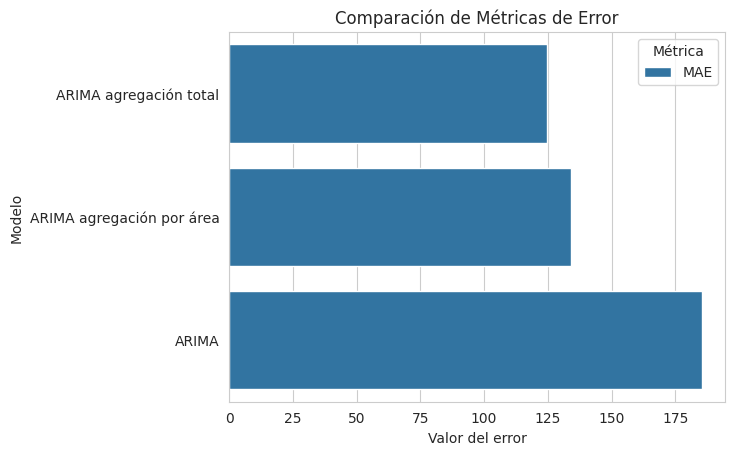

In [25]:
algo_type = "ARIMA"
df_algorithms = dataset_algorithms[algo_type]
df_best_algorithms[algo_type] = show_errors_and_get_best_model(algo_type, df_algorithms)

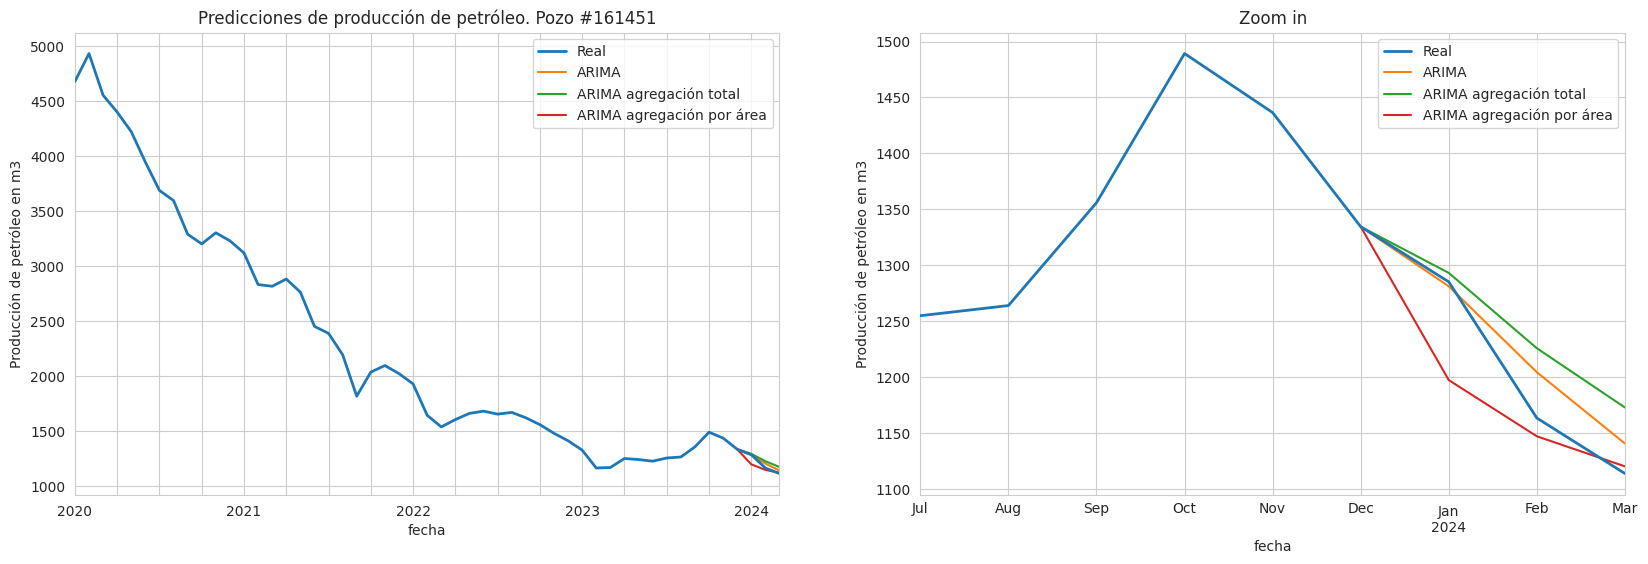

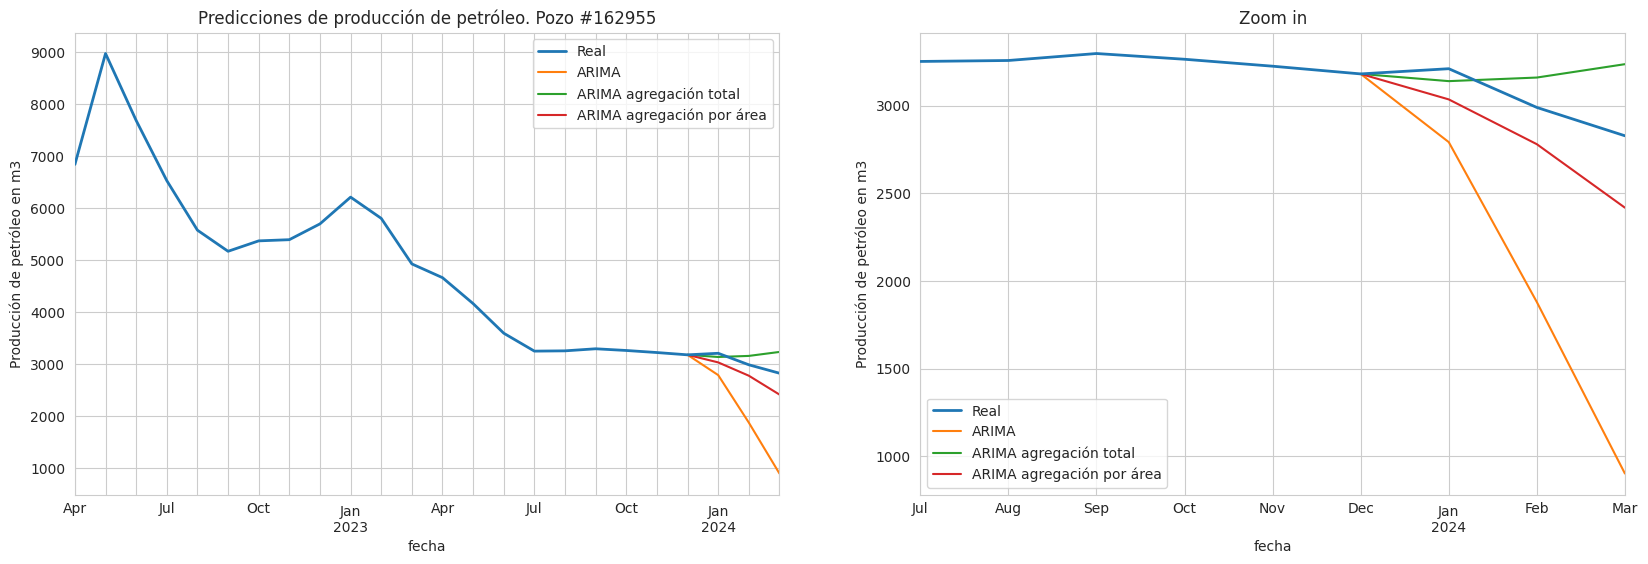

In [26]:
# Optional: 162405
for well_id in [161451, 162955]:
  plot_predictions_comparison_notebook(well_id, df_algorithms, plot_single_models=False)

In [27]:
# plot_residuals(df_algorithms)

In [28]:
# plot_boxplot_errors(df_algorithms)

## Resultados en Prophet

                        Modelo         MAE
0     Prophet agregación total  124.812164
1  Prophet agregación por área  130.360626
2                      Prophet  161.052547


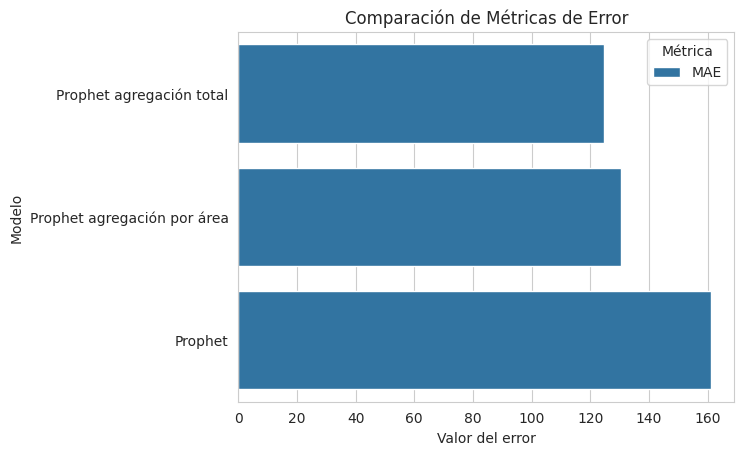

In [29]:
algo_type = "Prophet"
df_algorithms = dataset_algorithms[algo_type]
df_best_algorithms[algo_type] = show_errors_and_get_best_model(algo_type, df_algorithms)

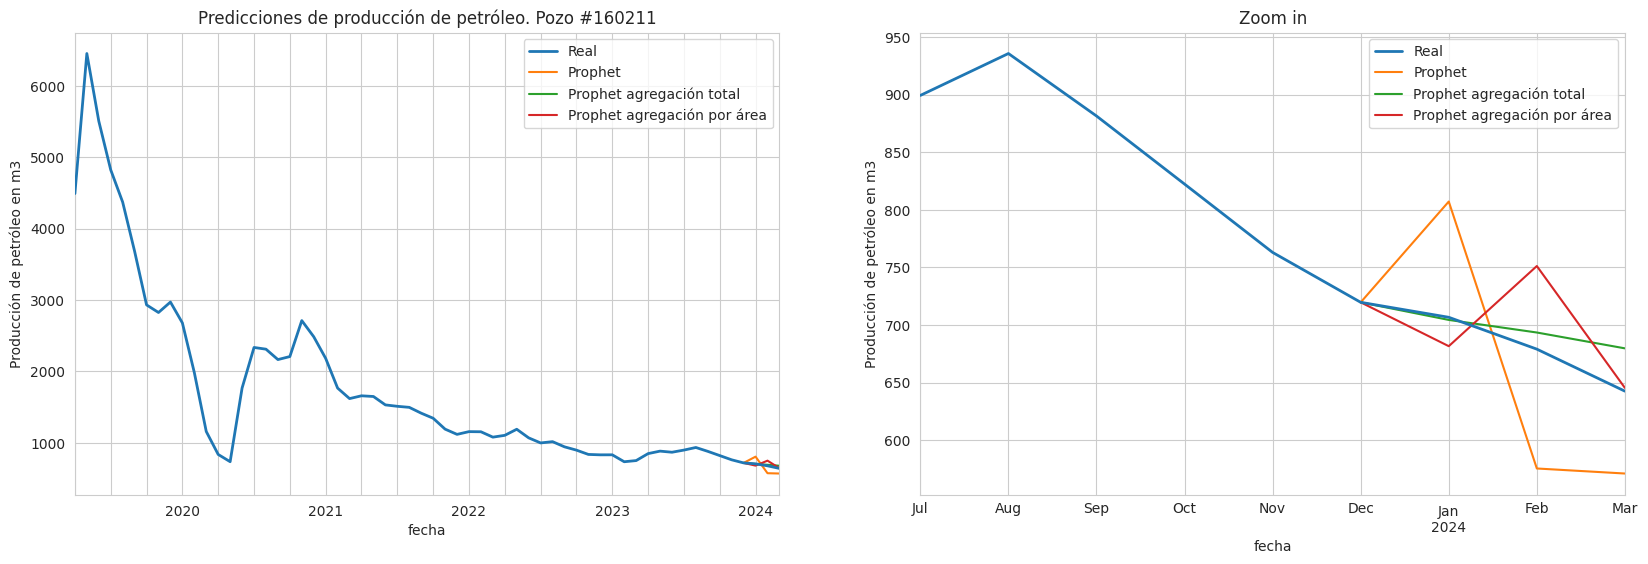

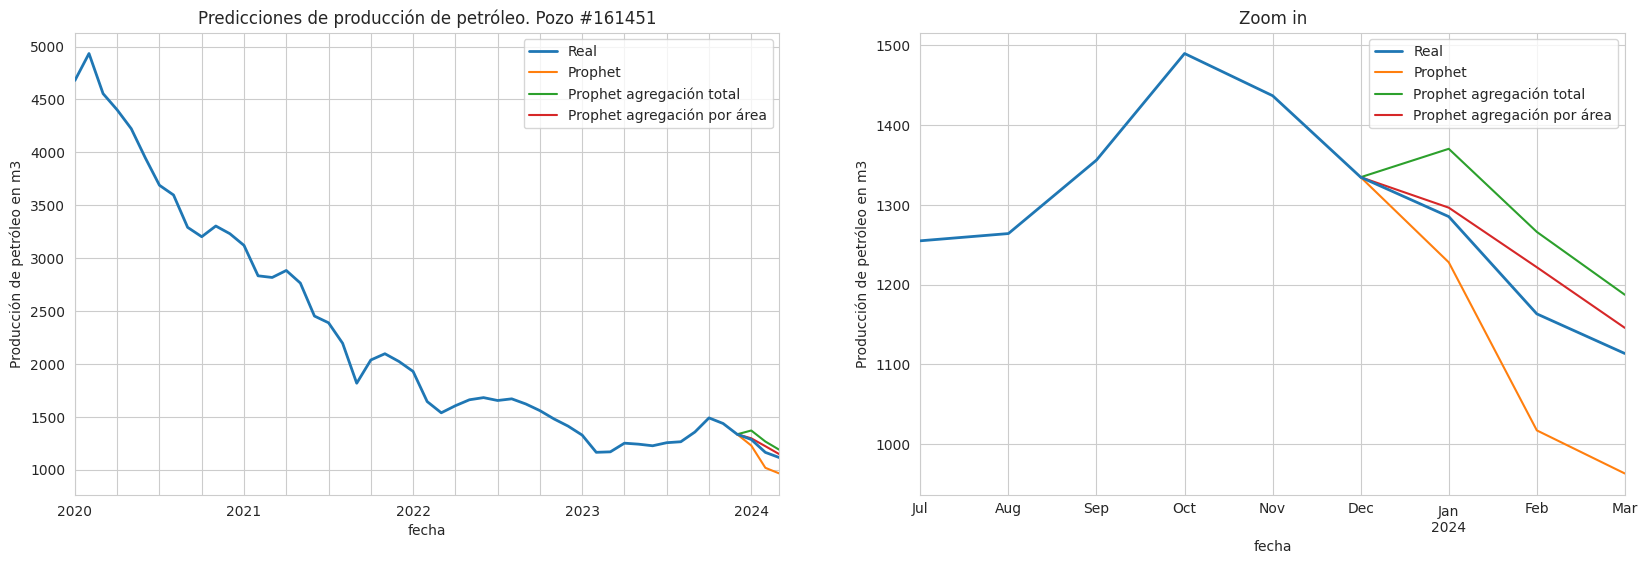

In [30]:
# Optional: 160814
for well_id in [160211, 161451]:
  plot_predictions_comparison_notebook(well_id, df_algorithms, plot_single_models=False)

In [31]:
# plot_residuals(df_algorithms)

In [32]:
# plot_boxplot_errors(df_algorithms)

## Resultados en GRU

                Modelo         MAE
0                  GRU  161.890747
1  GRU filtro por área  274.619867


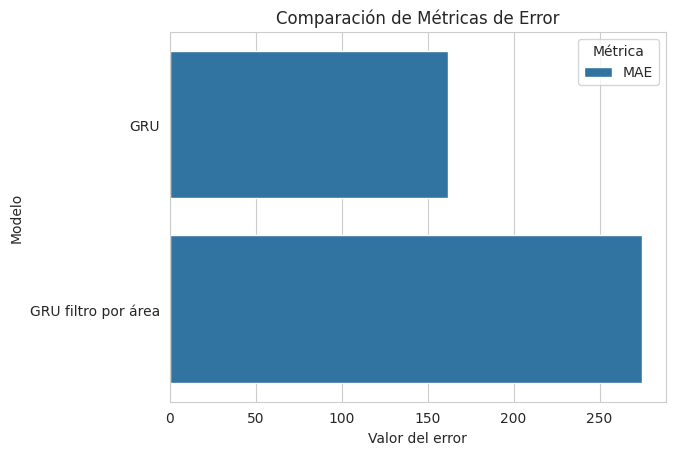

In [33]:
algo_type = "GRU"
df_algorithms = dataset_algorithms[algo_type]
df_best_algorithms[algo_type] = show_errors_and_get_best_model(algo_type, df_algorithms)

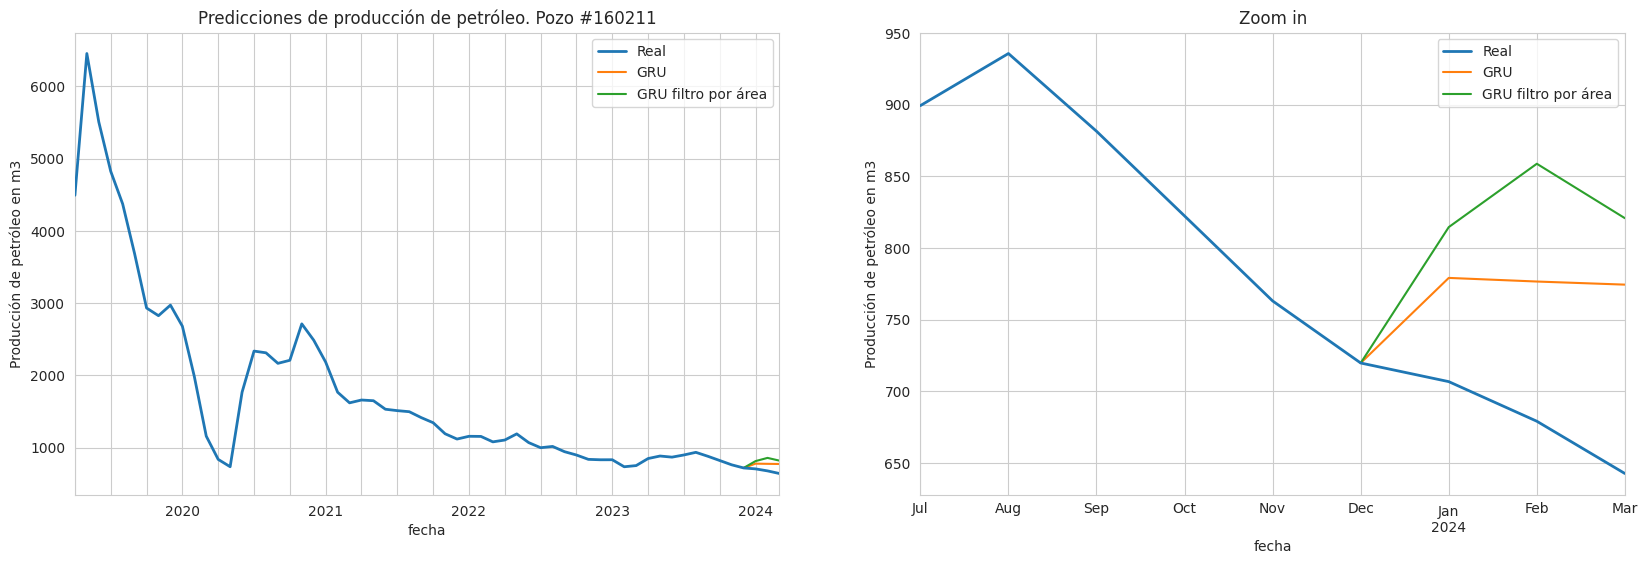

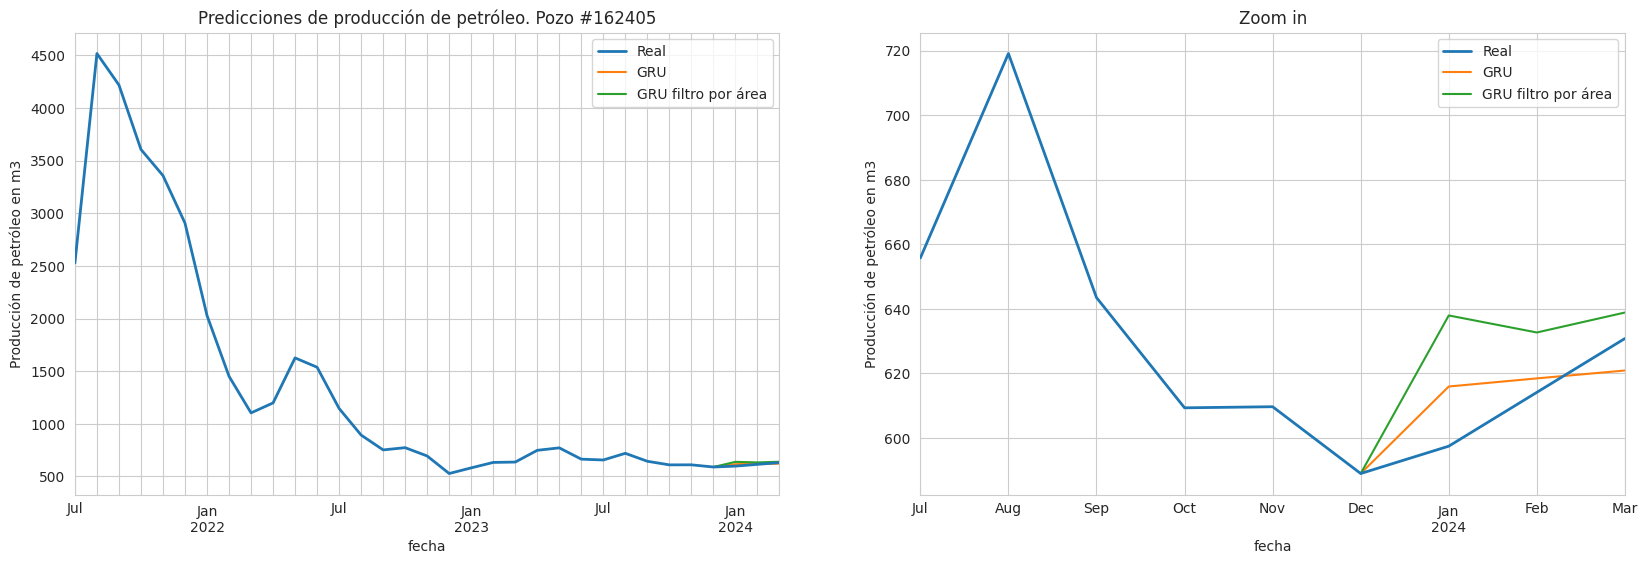

In [34]:
# Optional: 163237
for well_id in [160211, 162405]:
  plot_predictions_comparison_notebook(well_id, df_algorithms, plot_single_models=False)

In [35]:
# plot_residuals(df_algorithms)

In [36]:
# plot_boxplot_errors(df_algorithms)

## Resultados en LSTM

                                     Modelo         MAE
0  LSTM agregación por área - MSE 100 evals   90.410027
1      LSTM agregación total - MSE 50 evals  116.440368
2                      LSTM - MSE 100 evals  673.920439


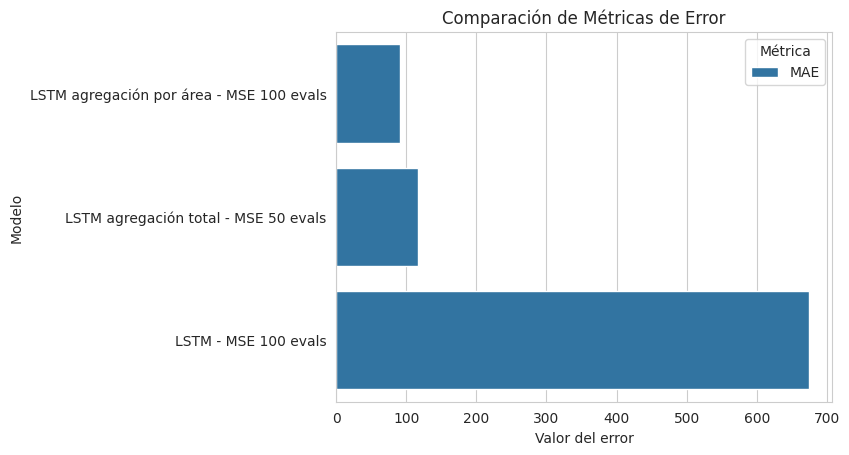

In [37]:
algo_type = "LSTM"
df_algorithms = dataset_algorithms[algo_type]
df_best_algorithms[algo_type] = show_errors_and_get_best_model(algo_type, df_algorithms)

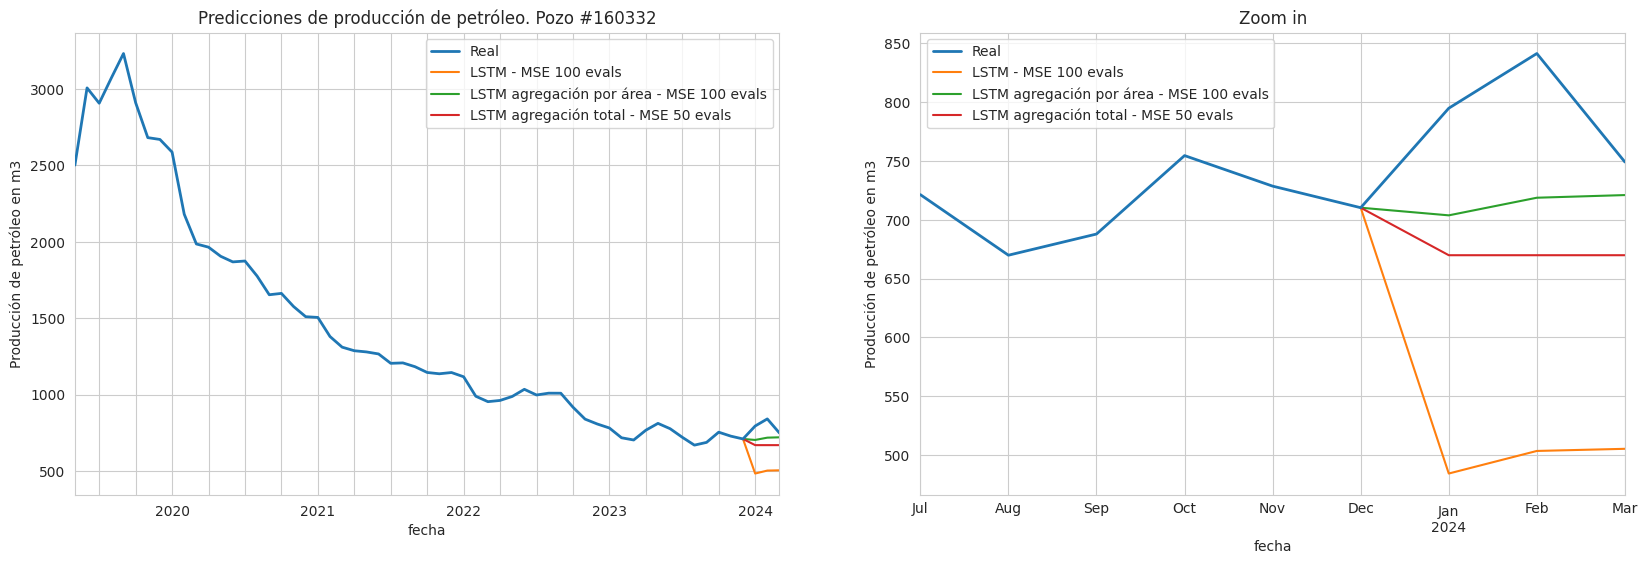

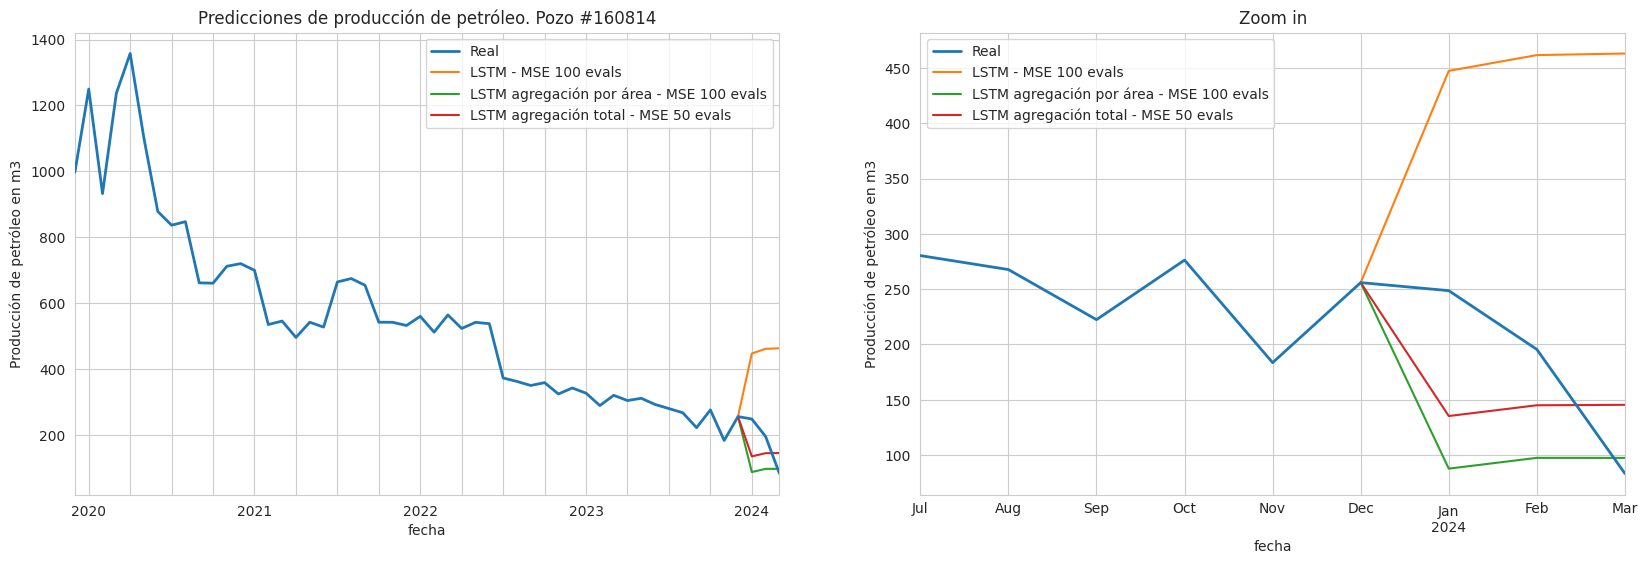

In [38]:
# Optional: 161451
for well_id in [160332, 160814]:
  plot_predictions_comparison_notebook(well_id, df_algorithms, plot_single_models=False)

In [39]:
# plot_residuals(df_algorithms)

In [40]:
# plot_boxplot_errors(df_algorithms, orient='h')

# Comparación de los mejores resultados
Una vez obtenidos los mejores resultados de cada modelo, se comparan entre si.

    Modelo         MAE
0     LSTM   90.410027
1    ARIMA  124.525666
2  Prophet  124.812164
3      GRU  161.890747


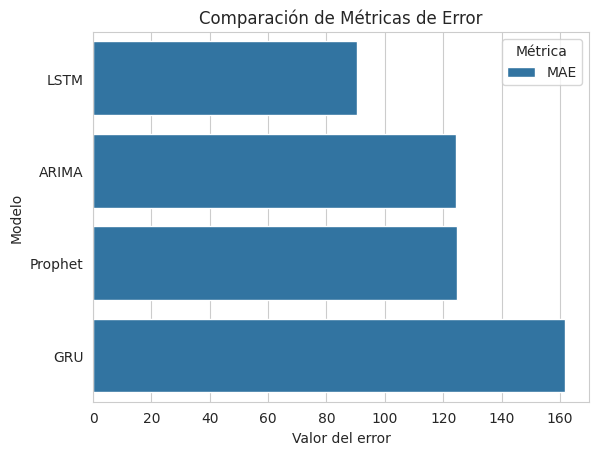

In [41]:
best = show_errors_and_get_best_model(algo_type, df_best_algorithms)

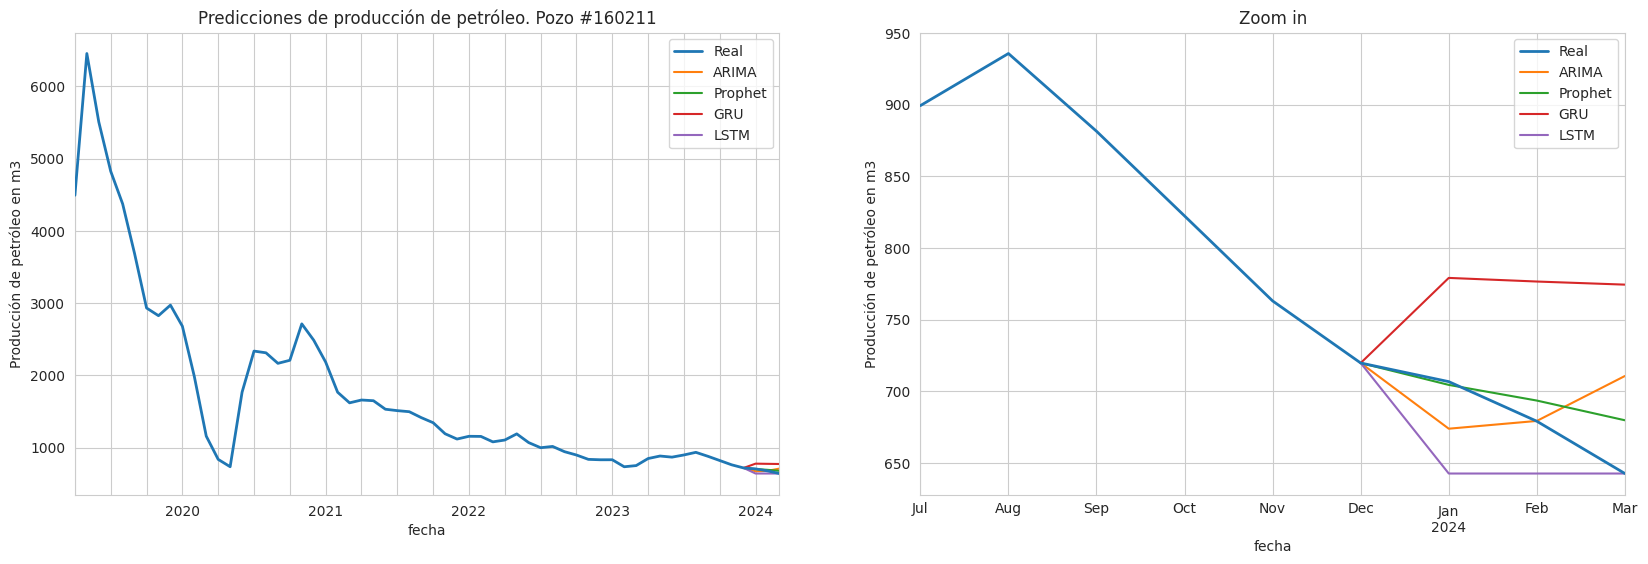

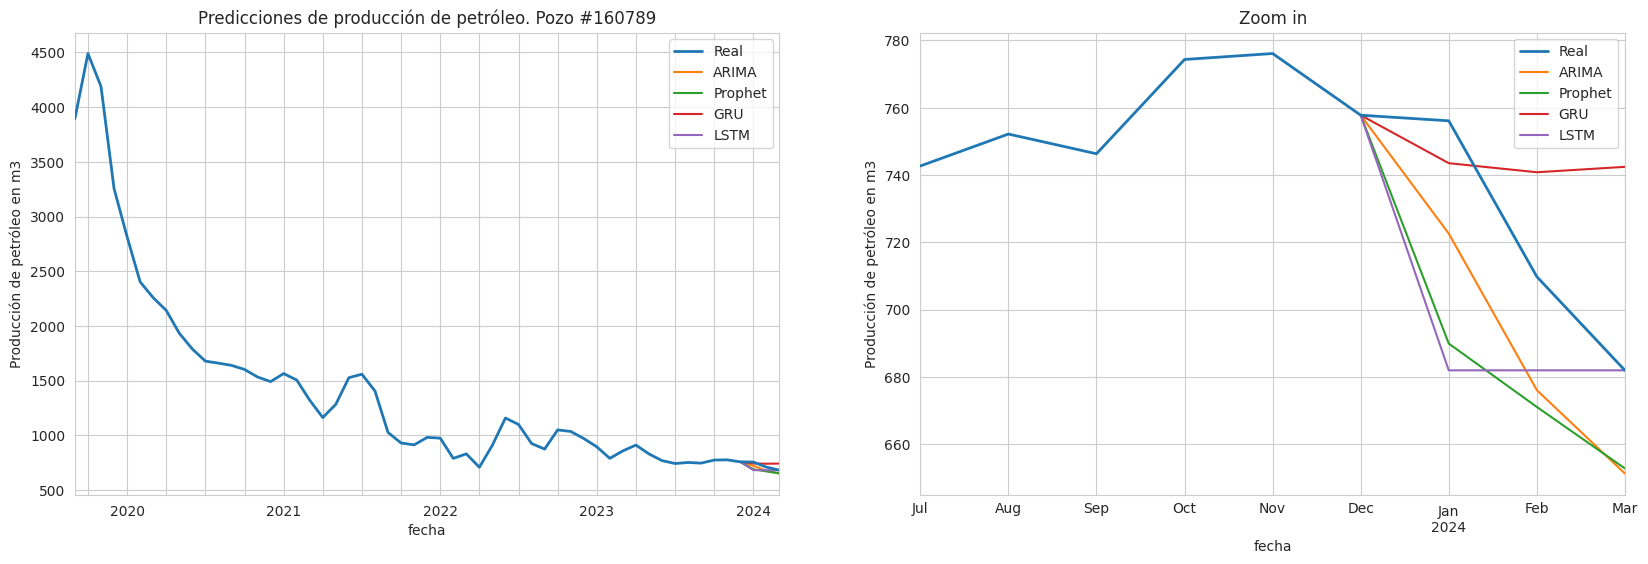

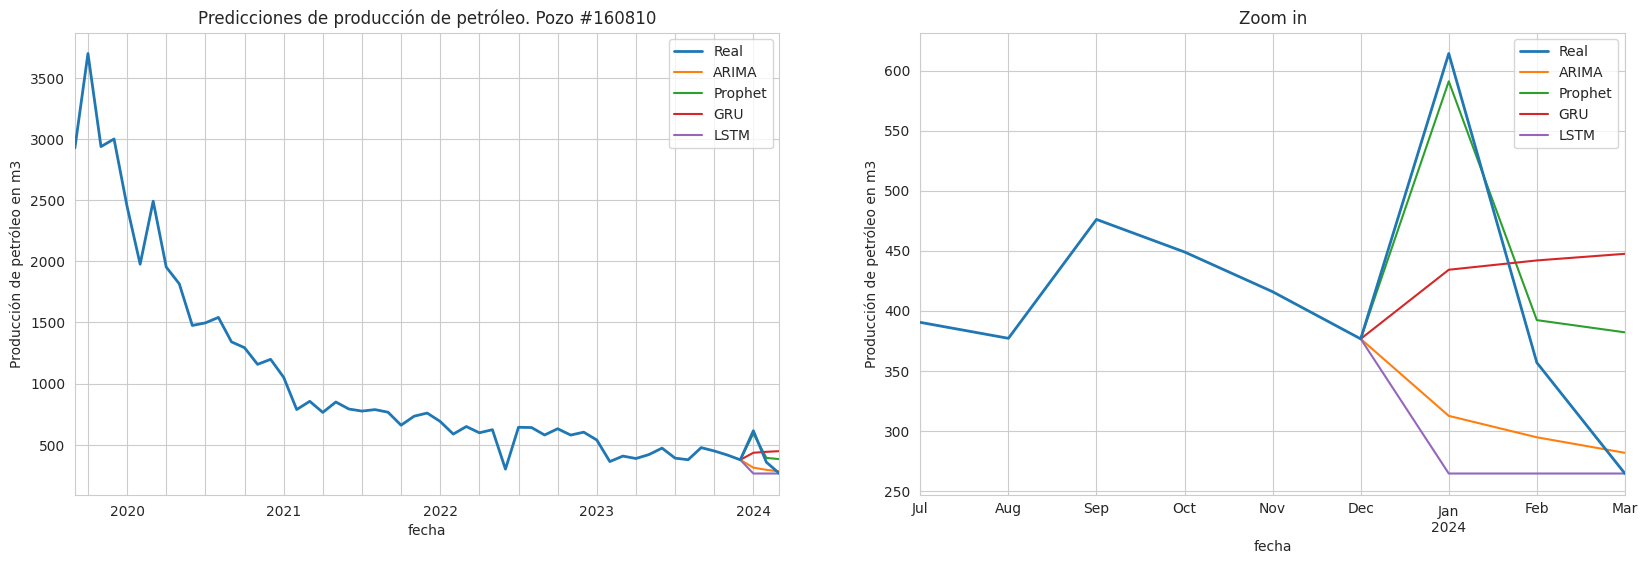

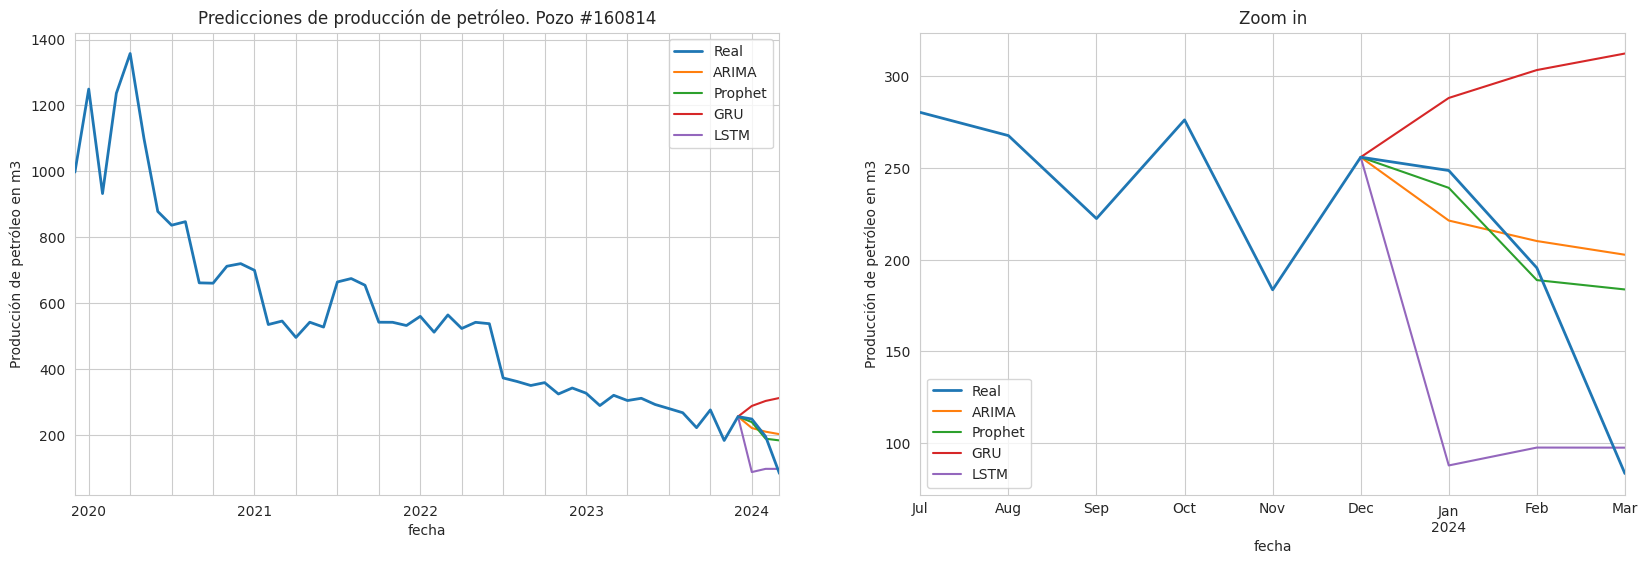

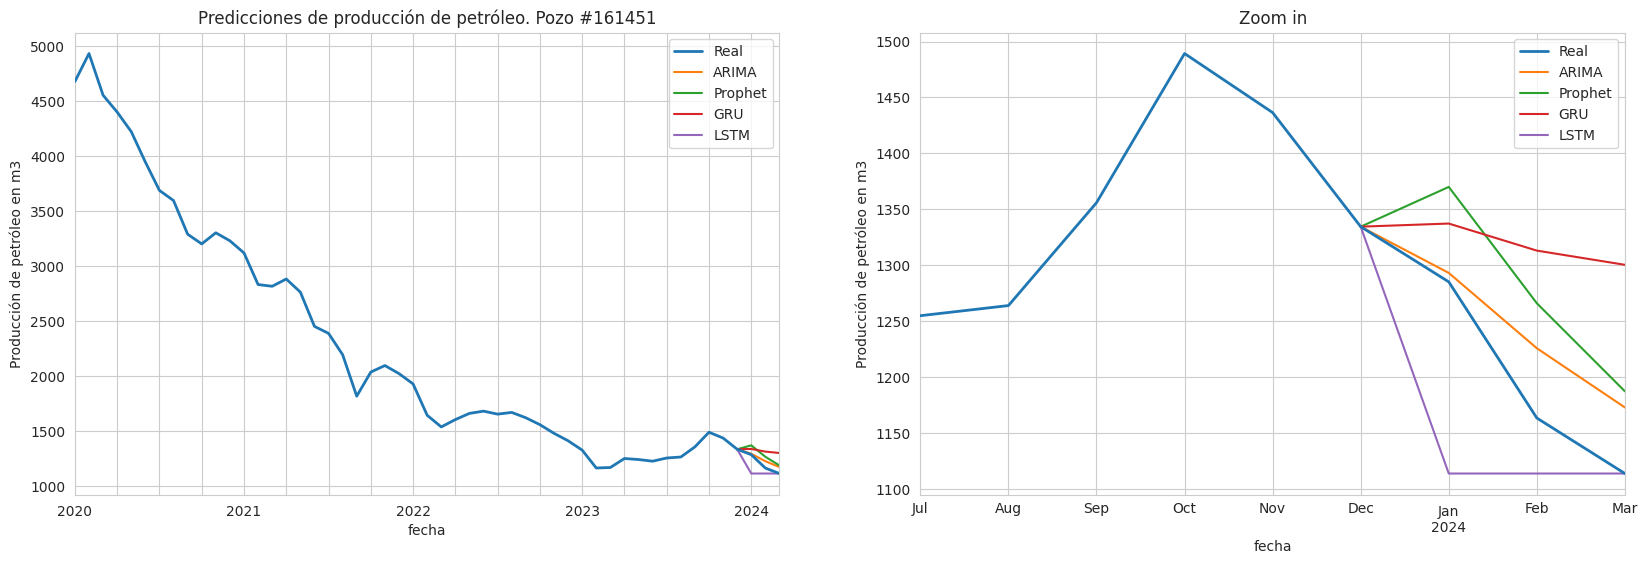

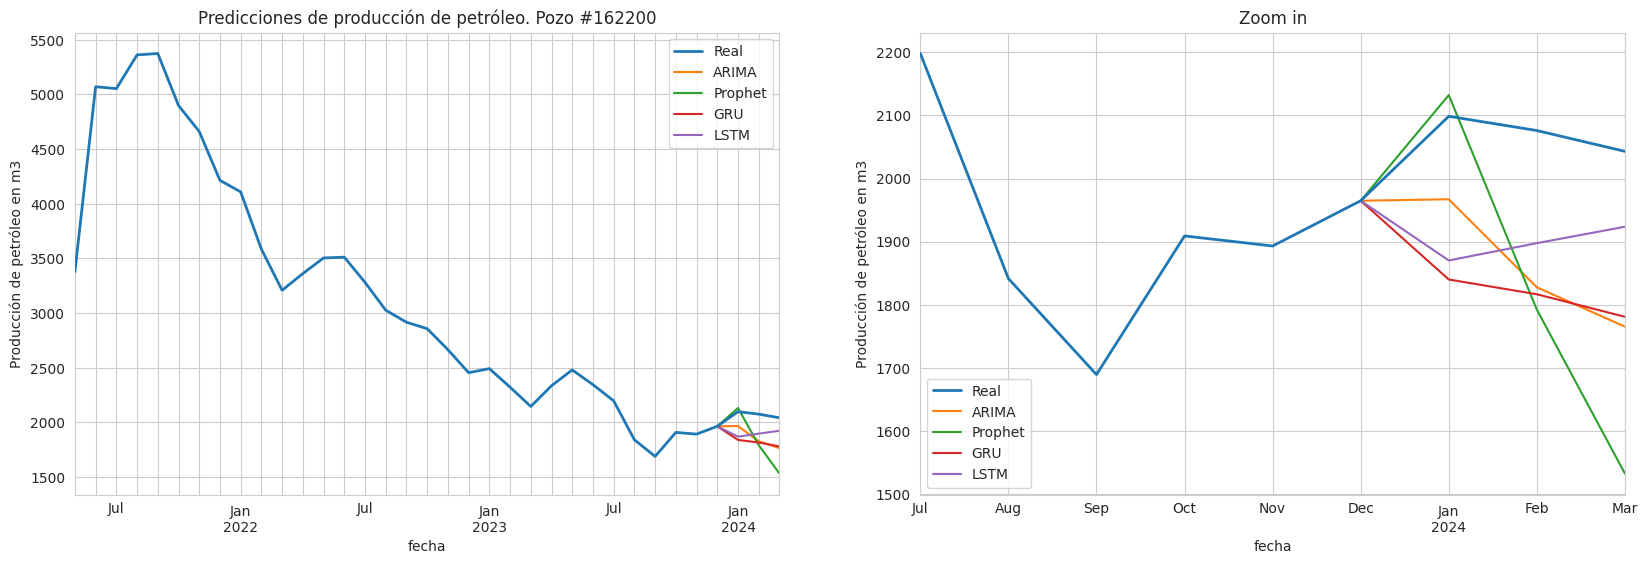

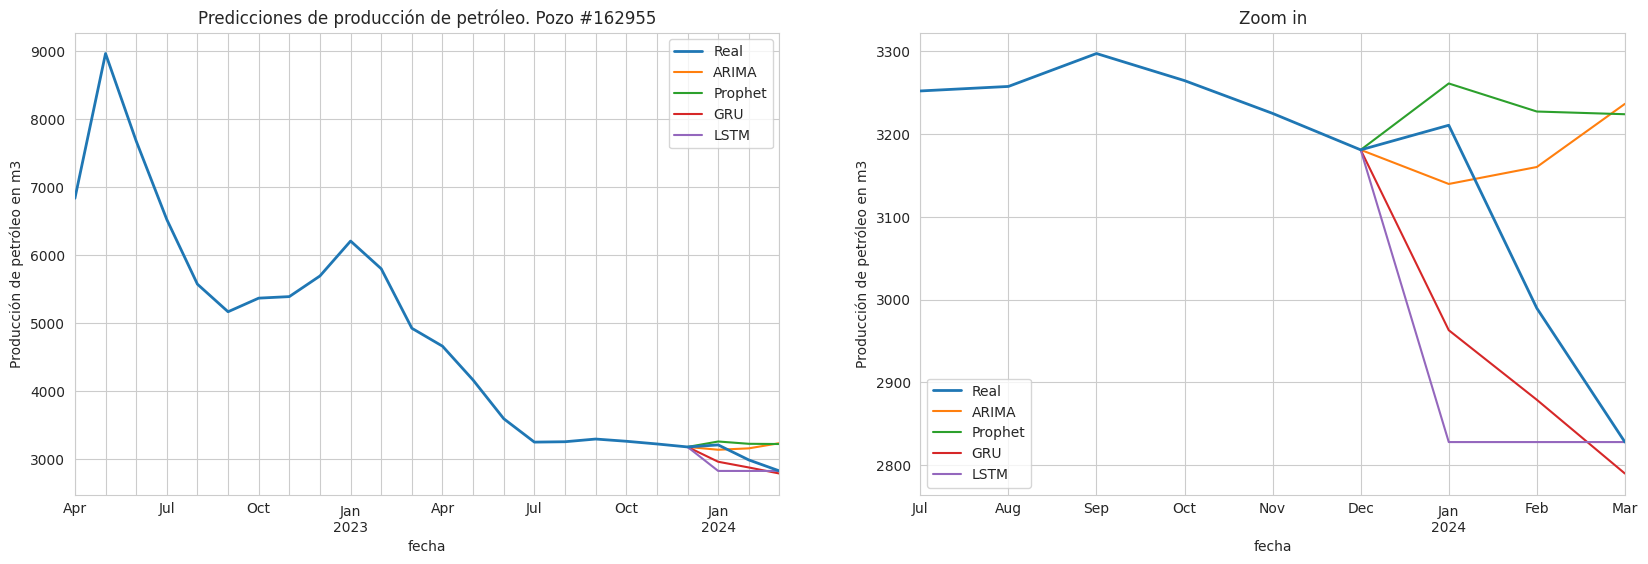

In [42]:
for well_id in [160211, 160789, 160810, 160814, 161451, 162200, 162955]:
  plot_predictions_comparison_notebook(well_id, df_best_algorithms, plot_single_models=False)

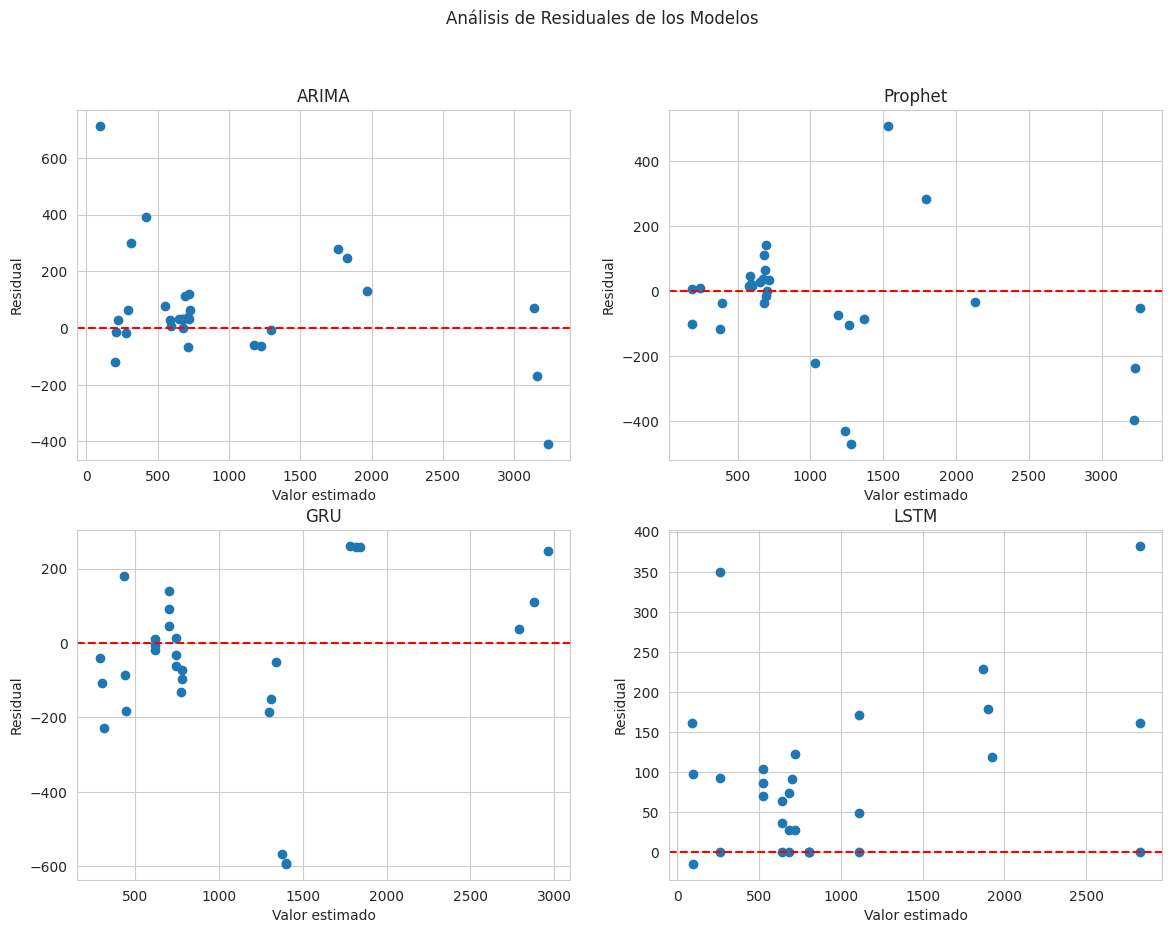

In [43]:
plot_residuals(df_best_algorithms)

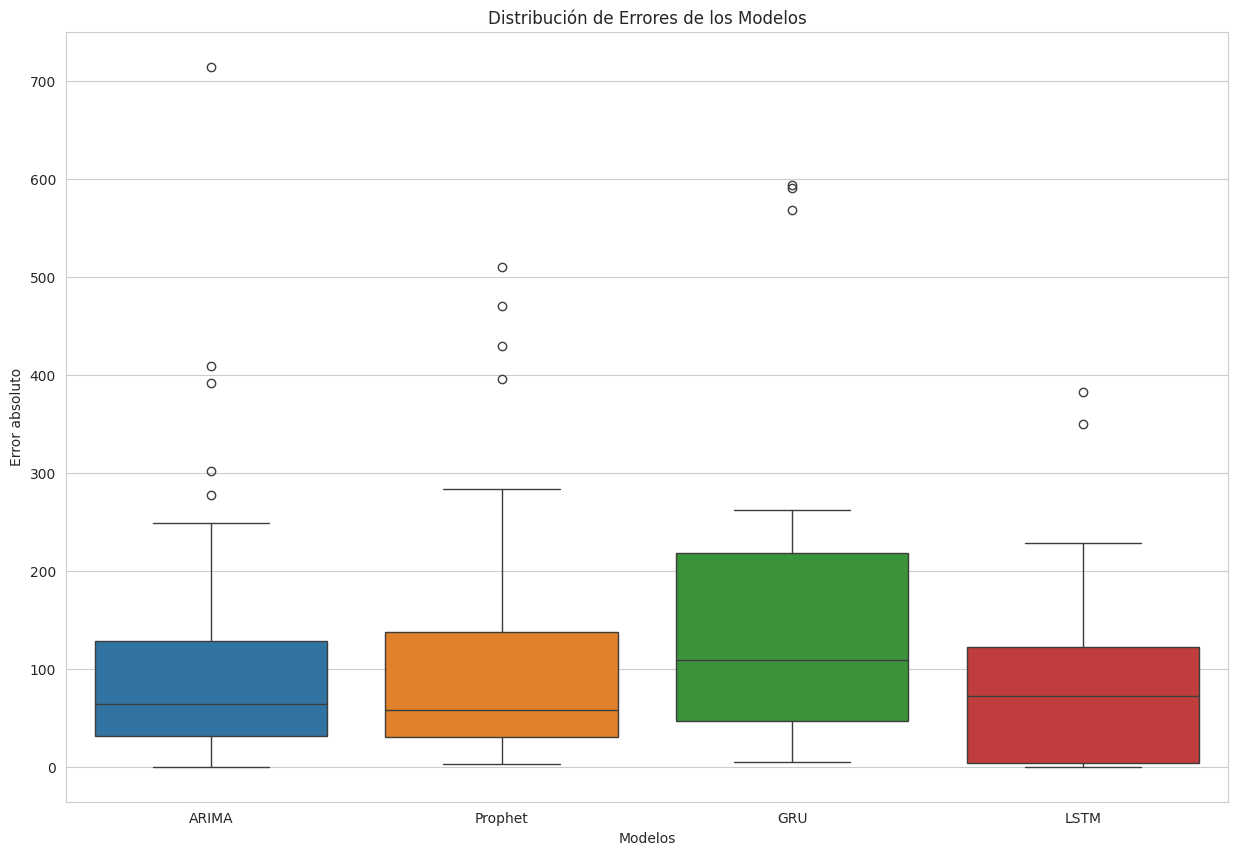

In [44]:
plot_boxplot_errors(df_best_algorithms)

In [45]:
for algo_type in dataset_algorithms.keys():
  print(f"================================= Algoritmos del tipo {algo_type} =================================")
  for algo_name in dataset_algorithms[algo_type].keys():
    print(f"--------------------------------- Algoritmo {algo_name} ---------------------------------")
    print(get_df_predictions_by_algorithm(dataset_test, dataset_algorithms[algo_type][algo_name]))

================================= Algoritmos del tipo GRU =================================
--------------------------------- Algoritmo GRU ---------------------------------
    idpozo      fecha  prod_pet_predicted  prod_pet_real       error
0   160211 2024-01-01           779.03840     706.649500  -72.388900
1   160332 2024-01-01           703.32440     794.935000   91.610600
2   160789 2024-01-01           743.51160     756.105150   12.593550
3   160810 2024-01-01           434.09613     614.192000  180.095870
4   160814 2024-01-01           288.29480     248.686000  -39.608800
5   161451 2024-01-01          1337.24160    1285.098000  -52.143600
6   162200 2024-01-01          1840.11020    2098.560000  258.449800
7   162405 2024-01-01           615.94617     597.466667  -18.479503
8   162955 2024-01-01          2962.98780    3210.536500  247.548700
9   163237 2024-01-01          1401.98990     808.230000 -593.759900
10  160211 2024-02-01           776.50930     679.006500  -97.50280